In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## PASCAL VOC data setup

In [2]:
# BASE_PATH = '/content/drive/MyDrive/ai/detection/detection-tutorial/'
BASE_PATH = '/content/drive/MyDrive/ai/detection/'

In [3]:
!ls {BASE_PATH}

detection-tutorial	 faster_rcnn_model_1.pth  VOCtrainval_11-May-2012.tar
detectron2_test.ipynb	 setup.ipynb
faster_rcnn_model_0.pth  training_results.ipynb


In [4]:
file = BASE_PATH + 'VOCtrainval_11-May-2012.tar'

In [5]:
%%time
!cp {file} .

CPU times: user 372 ms, sys: 70.6 ms, total: 442 ms
Wall time: 1min 13s


In [6]:
%%time
!tar -xvf ./VOCtrainval_11-May-2012.tar > /dev/null

CPU times: user 208 ms, sys: 39 ms, total: 247 ms
Wall time: 51.7 s


In [7]:
!pwd

/content


In [8]:
!ls

drive  sample_data  VOCdevkit  VOCtrainval_11-May-2012.tar


## Imports

In [9]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [10]:
import os
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

In [11]:
os.chdir("drive/My Drive/ai/detection/detection-tutorial")
# os.chdir("/content/")

In [12]:
# import sys
# sys.path.append('./dataset/')
# sys.path.append('./')
# sys.path

In [13]:
from transforms import get_transform
from utils import format_time, seed_everything
from utils import generate_anchors, find_jaccard_overlap
from utils_plot import show_predictions, show_image_and_bb, show_anchors, show_image_from_dataset

from loss import BoxLoss
from train import run_loader, get_device

from faster_rcnn import faster_rcnn

In [14]:
# !mkdir ./pascal-voc

In [15]:
# from dataset.pascal_voc_utils import create_data_lists
# create_data_lists(
#     voc07_path=None,
#     voc12_path='/content/VOCdevkit/VOC2012/',
#     # voc12_path='../VOCdevkit/VOC2012/',
#     output_folder='./pascal-voc/'
# )

In [16]:
SEED = 2021
seed_everything(SEED)

## PennFudanDataset

In [ ]:
from dataset.penn_fudan_dataset import PennFudanDataset

In [ ]:
# dataset = PennFudanDataset('../PennFudanPed', get_transform(train=False))
dataset = PennFudanDataset('../PennFudanPed', None)

In [ ]:
image, target = dataset[0]

In [ ]:
type(image)

PIL.Image.Image

In [ ]:
target

{'boxes': tensor([[159., 181., 301., 430.],
         [419., 170., 534., 485.]]),
 'labels': tensor([1, 1])}

tensor([159., 181., 301., 430.])
tensor([419., 170., 534., 485.])


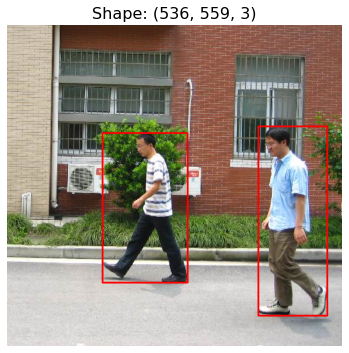

In [ ]:
# show_image(dataset, 0)
show_image_and_bb(image, target)

In [ ]:
anchors = generate_anchors()

In [ ]:
# anchors = anchors[:5]
anchors.shape

torch.Size([441, 4])

In [ ]:
# each anchor we need to match gt_box and binary label - positive
# or 0 label and no box - negative

# We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes.
# Anchors that are neither positive nor negative do not contribute to the training objective.

# + add delatas for loss

In [ ]:
anchor_labels, gt_offsets = process_anchors(anchors, target['boxes'])

In [ ]:
top_n_anchors, top_n_iou = get_top_n_anchors(anchors, target['boxes'])

In [ ]:
top_n_iou

tensor([0.4745, 0.4732, 0.4732, 0.4691, 0.4008, 0.3733, 0.3733, 0.3644, 0.3631,
        0.3602])

In [ ]:
N = 9
start = 24
# show_anchors(image, target['boxes'], anchors[start*N:(start+1)*N])
# show_anchors(image, target['boxes'], anchors)

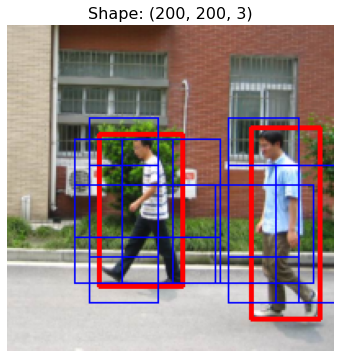

In [ ]:
show_anchors(image, target['boxes'], top_n_anchors)

## PASCAL VOC dataset

In [17]:
from dataset.pascal_voc_dataset import PascalVOCDataset
from utils import generate_anchors

In [18]:
# dataset = PascalVOCDataset('/content/pascal-voc/', 'TRAIN', get_transform(train=True))
dataset = PascalVOCDataset('./pascal-voc/', 'TRAIN', get_transform(train=True))

In [19]:
generate_anchors_settings = dict(
    clip=False,
    feature_dims = [25, 13, 7, 4], # TODO: Read from image?
    # scales = [0.9, 0.6, 0.3],
    feature_map_scales = [0.2, 0.4, 0.6, 0.8],
    aspect_ratios = [1., 2., 0.5],
)

In [20]:
anchors = generate_anchors(generate_anchors_settings)
anchors.shape

torch.Size([2577, 4])

In [21]:
N = 3
feature_dims = np.array([25, 13, 7, 4])
(feature_dims**2).cumsum()

array([625, 794, 843, 859])

GT:
tensor([107.6000,   0.0000, 150.8000, 107.0336])
tensor([22.4000,  0.0000, 65.2000, 91.1315])
Predictions:
tensor([ 80.0000, 112.0000, 120.0000, 152.0000])
tensor([ 71.7157, 117.8579, 128.2843, 146.1421])
tensor([ 85.8579, 103.7157, 114.1421, 160.2843])
Shape: (200, 200, 3)


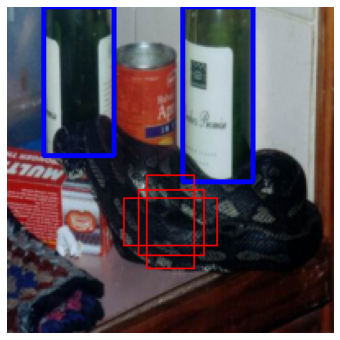

In [22]:
index = 5
image, target = dataset[index]

gt_boxes = target['boxes']

start = 316
anchors_to_show = anchors[start*N:(start+1)*N]

plt.figure(figsize=(6,6))
# show_image_and_bb(image, target['boxes'])
show_predictions(image, gt_boxes, anchors_to_show, verbose=True)

In [ ]:
from torchvision.ops import boxes as box_ops
box_similarity = box_ops.box_iou

In [ ]:
index = 4
image, target = dataset[index]
gt_boxes = target['boxes']

anchors = generate_anchors(clip=True)

In [ ]:
gt_boxes

tensor([[0.4320, 0.4267, 0.5860, 0.5867],
        [0.9280, 0.4427, 0.9980, 0.5787]])

In [ ]:
threshold = 0.5
# jaccard = find_jaccard_overlap(anchors, gt_boxes)
jaccard = box_similarity(anchors, gt_boxes)
print(jaccard.shape)

torch.Size([2577, 2])


In [ ]:
def get_positive_anchors(anchors, gt_boxes, threshold=0.3):
    # anchors (N1, 4)
    # gt_boxes (N2, 4)

    jaccard = find_jaccard_overlap(anchors, gt_boxes) # (N1, N2)

    max_iou_for_anchors, gt_boxes_id_for_anchors = jaccard.max(1) # (N1), (N1)

    # fix cases when gt box has no anchor above threshold
    n_objects = gt_boxes.shape[0]
    _, anchor_id_for_object = jaccard.max(0) # (N2), (N2)
    gt_boxes_id_for_anchors[anchor_id_for_object] = torch.LongTensor(range(n_objects))
    max_iou_for_anchors[anchor_id_for_object] = 1

    positive_anchors_mask = (max_iou_for_anchors > threshold) # (N1)
    gt_boxes_id_for_positive_anchors = gt_boxes_id_for_anchors[positive_anchors_mask] # (n_pos_anchors)

    gt_boxes_for_positive_anchors = gt_boxes[gt_boxes_id_for_positive_anchors]  # (n_pos_anchors, 4)
    positive_anchors = anchors[positive_anchors_mask] # (n_pos_anchors, 4)
    positive_iou = max_iou_for_anchors[positive_anchors_mask] # (n_pos_anchors, 1)
    
    return positive_anchors, positive_iou, gt_boxes_for_positive_anchors

Positive anchors number: 1/12885


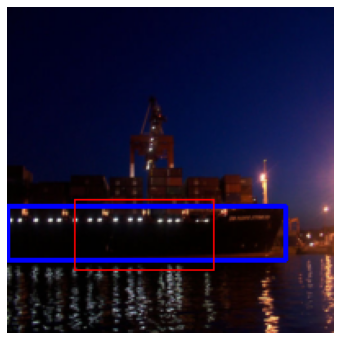

In [ ]:
index = 2
image, target = dataset[index]
gt_boxes = target['boxes']

anchors = generate_anchors(clip=True)

top_n_anchors, top_n_iou, pos_gt_boxes = get_positive_anchors(anchors, gt_boxes, threshold=0.5)
# top_n_anchors, top_n_iou = get_top_n_anchors(anchors, gt_boxes, top_n=10)

print(f'Positive anchors number: {top_n_anchors.shape[0]}/{anchors.shape[0]}')
# print(top_n_iou)

plt.figure(figsize=(6,6))
# show_image_and_bb(image, target['boxes'])
show_predictions(image, gt_boxes, top_n_anchors, verbose=False)

In [ ]:
# index = 5
# show_image_from_dataset(dataset, index, top_n_anchors=10, verbose=True)

## Model single path

In [23]:
device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [24]:
def collate_fn(batch):
    # batch: list[tuple]
    # each tuple is (image, target) dictionary
    # turns it into a single tuple (in this case of len == 2)
    
    # TODO: why it's always tuple  
    # print(f'collate_fn, {len(batch)}, {list(zip(*batch))[0]}, {type(list(zip(*batch))[0])}')
    # return list(zip(*batch))
    
    # torch.stack here? for images?
    # do we distinguish targets between images?
    
    return tuple(zip(*batch))

In [25]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

In [26]:
images, targets = next(iter(data_loader))
images = torch.stack(images, dim=0).to(device)
images.shape

torch.Size([8, 3, 200, 200])

In [27]:
# targets

In [29]:
net = faster_rcnn(device, generate_anchors_settings).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [31]:
offsets, labels = net(images)
offsets.shape, labels.shape

(torch.Size([8, 2577, 4]), torch.Size([8, 2577, 1]))

In [32]:
box_loss_settings = dict(
    anchor_threshold = 0.3,
    fix_no_anchors = False,

    # Hard Negative Mining settings
    enable_hnm = False,
    neg_pos_ratio = 3.0
)

In [33]:
criterion = BoxLoss(device, box_loss_settings, net.anchors)

In [34]:
loss = criterion(labels, offsets, targets)

anchors pos: 1095, neg: 19521


In [35]:
loss

(tensor(2.4702, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6630, device='cuda:0', grad_fn=<SmoothL1LossBackward>),
 tensor(0.8072, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>))

In [ ]:
-np.log(1/2)

0.6931471805599453

In [ ]:
gt_labels, gt_offsets = criterion.process_target_batch(targets)

In [ ]:
gt_labels.shape

torch.Size([8, 2577])

In [ ]:
torch.unique(gt_labels, return_counts=True)

(tensor([0, 1], dtype=torch.int32), tensor([19520,  1096]))

In [ ]:
torch.unique(torch.tensor([1,1,0,2]), return_counts=True)

(tensor([0, 1, 2]), tensor([1, 2, 1]))

## Train Model

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
len(train_loader)

1443

In [ ]:
params = {
    'learning_rate' : 0.001,
    'weight_decay'  : 0,
    'num_epoch'     : 2
}

model = faster_rcnn()

run_loader(model, train_loader, None, **params)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
[train] index:  0, loss(box/cls) = 2.51103(1.77640/0.73463) time: 0:00:00


/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:47: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  boxes = boxes[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:48: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  labels = labels[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:49: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  difficulties = difficulties[1 - difficulties]


[train] index: 100, loss(box/cls) = 2.08980(1.67377/0.41603) time: 0:00:07
[train] index: 200, loss(box/cls) = 1.53724(1.12103/0.41621) time: 0:00:14
[train] index: 300, loss(box/cls) = 1.54284(1.17414/0.36871) time: 0:00:20
[train] index: 400, loss(box/cls) = 1.33409(0.94387/0.39022) time: 0:00:27
[train] index: 500, loss(box/cls) = 1.23265(0.95894/0.27371) time: 0:00:34
[train] index: 600, loss(box/cls) = 1.47188(1.15760/0.31429) time: 0:00:41
[train] index: 700, loss(box/cls) = 1.38084(1.11081/0.27003) time: 0:00:48
[train] index: 800, loss(box/cls) = 1.13748(0.78485/0.35264) time: 0:00:54
[train] index: 900, loss(box/cls) = 1.44728(1.20427/0.24301) time: 0:01:01
[train] index: 1000, loss(box/cls) = 1.23932(0.86597/0.37335) time: 0:01:08
[train] index: 1100, loss(box/cls) = 0.96726(0.75159/0.21567) time: 0:01:14
[train] index: 1200, loss(box/cls) = 1.32545(1.02724/0.29821) time: 0:01:21
[train] index: 1300, loss(box/cls) = 1.23931(0.93166/0.30765) time: 0:01:28
[train] index: 1400, 

{}

## Run

In [36]:
from train import main, run

In [37]:
from utils_plot import show_loss_history, show_loss_epochs_all, show_scores

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
# train_info = main(debug=True)

In [ ]:
generate_anchors_settings = dict(
    clip=False,
    feature_dims = [25, 13, 7, 4], # TODO: Read from image?
    # scales = [0.9, 0.6, 0.3],
    feature_map_scales = [0.2, 0.4, 0.6, 0.8],
    aspect_ratios = [1., 2., 0.5],
)

box_loss_settings = dict(
    anchor_threshold = 0.3,
    fix_no_anchors = True,

    # Hard Negative Mining settings
    enable_hnm = True,
    neg_pos_ratio = 3.0
)

params = {
    'generate_anchors_settings' : generate_anchors_settings,
    'box_loss_settings' : box_loss_settings,

    # 'rpn_heads'         : 0,

    'learning_rate'     : 0.001,
    'weight_decay'      : 0,
    'batch_size'        : 1,
    'num_epoch'         : 5,
    'verbose'           : True,
    'print_params'      : False, # False in notebook
    'debug'             : False
}
seed_everything(SEED)
train_info, valid_loader, model = run(**params)

data size, all: 11540, train: 10386
data loader size, train: 10386, valid: 1154
batch_size = 1
There are 1 GPU(s) available.
We will use the GPU: Tesla T4
training started...
[train] epoch:  1, loss(box/cls) = 3.19645(1.03943/2.15702), time: 0:04:37
[valid] epoch:  1, loss(box/cls) = 3.10296(1.00500/2.09796), mAP = 0.18490,  time: 0:04:57
[train] epoch:  2, loss(box/cls) = 2.95409(0.92621/2.02788), time: 0:04:40
[valid] epoch:  2, loss(box/cls) = 2.91925(0.93255/1.98671), mAP = 0.16320,  time: 0:04:59


In [ ]:
epochs = 120000 // (len(dataset) // 32)
epochs

In [ ]:
# train_info['train_cls_loss_history']

In [ ]:
show_loss_history(train_info)

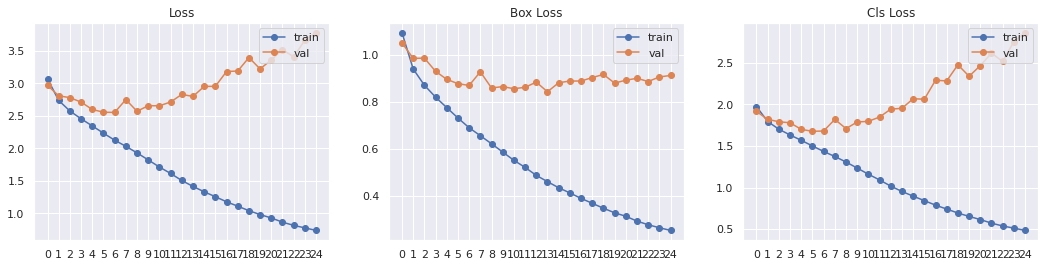

In [ ]:
show_loss_epochs_all(train_info)

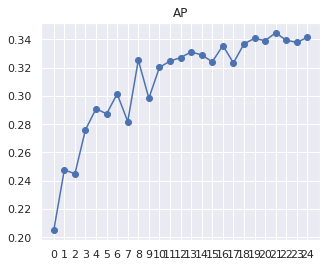

In [ ]:
show_scores(train_info)

In [ ]:
model_path = os.path.join(BASE_PATH, 'faster_rcnn_model_1.pth')
torch.save(model.state_dict(), model_path)

## Show predictions

In [ ]:
from utils_plot import show_predictions

In [ ]:
device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
len(valid_loader)

145

In [ ]:
images, targets = next(iter(valid_loader))

In [ ]:
images = torch.stack(images, dim=0).to(device)

In [ ]:
# model = faster_rcnn(device)

# model_path = '../pth/faster_rcnn_model_0.pth'
# model.load_state_dict(torch.load(model_path, map_location='cpu'))

# model_path = os.path.join(BASE_PATH, 'faster_rcnn_model_0.pth')
# model.load_state_dict(torch.load(model_path))

In [ ]:
model.eval()
print('')

In [ ]:
offsets, labels = model(images)

In [ ]:
pred_boxes, pred_conf = model.detect(offsets, labels, prob_threshold=0.5, max_overlap=0.5)

GT:
tensor([144.6429, 102.3810, 160.7143, 144.6429])
tensor([137.5000,  98.2143, 153.1250, 142.8571])
tensor([123.6607,  96.4286, 144.1964, 135.7143])
tensor([114.2857,  97.6190, 134.3750, 135.1190])
tensor([ 79.4643,  98.8095, 113.3929, 114.8810])
tensor([ 62.0536,  90.4762,  73.6607, 108.3333])
tensor([ 41.9643, 102.3810,  77.6786, 147.6190])
tensor([ 24.5536, 101.7857,  52.2321, 141.6667])
Predictions:
tensor([ 44.7883, 106.8309,  78.4910, 146.1841], grad_fn=<UnbindBackward>)
tensor([ 75.2990,  99.1152, 106.8766, 133.0520], grad_fn=<UnbindBackward>)
tensor([ 59.1610, 106.2459,  92.3455, 138.9675], grad_fn=<UnbindBackward>)
tensor([ 89.2673, 101.7287, 119.4452, 131.2637], grad_fn=<UnbindBackward>)
tensor([127.5795, 109.6379, 150.9665, 139.9365], grad_fn=<UnbindBackward>)
tensor([ 39.1750, 114.8763,  69.2740, 156.7926], grad_fn=<UnbindBackward>)
tensor([ 99.4149, 103.5807, 125.4809, 133.9961], grad_fn=<UnbindBackward>)
tensor([119.5994, 105.9957, 143.8738, 135.7589], grad_fn=<UnbindBa

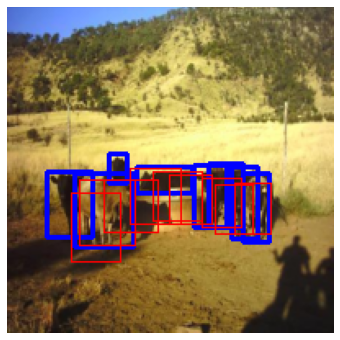

In [ ]:
plt.figure(figsize=(6,6))
image_index = 7
gt_boxes = targets[image_index]['boxes']
final_boxes = pred_boxes[image_index].cpu()
show_predictions(images[image_index], gt_boxes, final_boxes, verbose=True)

## Evaluation

In [ ]:
from utils import calculate_mAP

In [ ]:
det_boxes = pred_boxes
det_scores = pred_conf
true_boxes = [t['boxes'] for t in targets]
true_labels = [t['labels'] for t in targets]

NameError: ignored

In [ ]:
calculate_mAP(pred_boxes, pred_conf, true_boxes, true_labels, device)

tensor(0.3829, device='cuda:0')

In [ ]:
from train import validate

In [ ]:
criterion = BoxLoss(device)

In [ ]:
loss_meters, mAP = validate(model, device, criterion, valid_loader)

[valid] index:  0, loss(box/cls) = 0.55522(0.36432/0.19090) time: 0:00:00
[valid] index: 100, loss(box/cls) = 0.52522(0.37740/0.14782) time: 0:00:08
[valid] calculate_mAP... time: 0:00:12
[valid] mAP = 0.24425,  time: 0:00:13


In [ ]:
mAP

tensor(0.2871, device='cuda:0')

## ipywidgets

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

In [ ]:
# dataset = PascalVOCDataset('./pascal-voc/', transforms=get_transform(train=True))
dataset = PascalVOCDataset('./pascal-voc/')

get_transform_to_show


In [ ]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(dataset),
    step=1,
    description='Image:',
    disabled=False
)

def handle_change(x):
    print(x)
    show_image_from_dataset(dataset, x, top_n_anchors=0)

In [ ]:
# do it only once

# import json
# # with open('./pascal-voc/label_map.json'), 'r') as j:
# data_folder = './pascal-voc'
# with open(os.path.join(data_folder, 'label_map.json'), 'r') as j:
#     labels = json.load(j)

In [ ]:
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=0, description='Image:', max=11540), Output()), _dom_classes=('widg…

<function __main__.handle_change(x)>

## Trainimg